In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sys
sys.path.append('./zdrojaky')
from tsplot import tsplot
from statsmodels import tsa
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.api import qqplot
from IPython.display import display, Markdown

# Four-weekly totals of beer shipments
Čtyřtýdení součty objednávek piva. Rok neznámý, proto jako pravděpodobný rok byl zvolen rok 1970.

In [11]:
df = pd.read_csv('fourweekly-totals-of-beer-shipme.csv')
df.info()
df.index = df["Week"]
df = df.drop("Week", axis=1)
fn = 'fourweekly-totals-of-beer-shipme.csv'
# Vyberu z datasetu pouze součtu objednávek v jednotlivých týdnech
data = df['Four-weekly totals of beer shipments'].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 2 columns):
Week                                    52 non-null object
Four-weekly totals of beer shipments    52 non-null int64
dtypes: int64(1), object(1)
memory usage: 912.0+ bytes


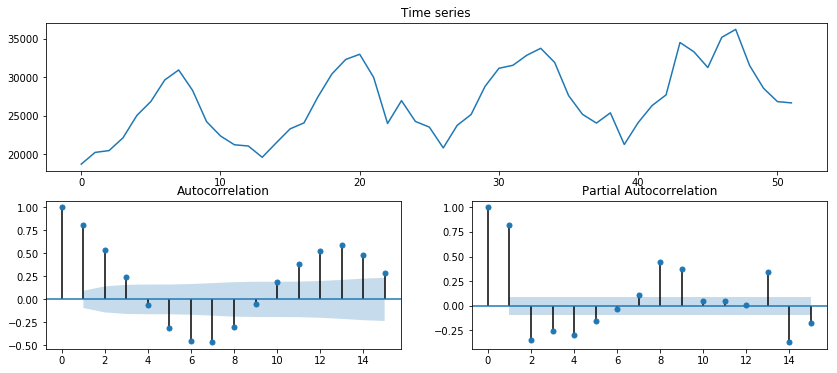

In [10]:
tsplot(data)

In [ ]:
Při pohledu na časovou řadu je patrná sez

Zdroj dat: <https://datamarket.com/data/set/2325/four-weekly-totals-of-beer-shipments#!ds=2325&display=line>